# Projeto Base de Dados Avaliação de Imóveis

Por SEFMG

Data: 2018

In [58]:
import pandas as pd
import json
from timeit import default_timer as timer
import numpy as np
import requests
import re
import os
pd.set_option('display.max_colwidth', -1)

## Juntando informação

In [59]:
# lER ARQUIVO HISTORICO SEF e armazenar em Pandas DataFrame

#Indexar pela coluna cep

xlsx = pd.ExcelFile('Historico_SEF3.xlsx')

df_Historico_SEF = pd.read_excel(xlsx, sheet_name=0, header=0)

In [60]:
# lER ARQUIVO CEP_Completo e armazenar em Pandas DataFrame

#Indexar pela coluna cep

xlsx = pd.ExcelFile('CEP_Completo.xlsx')

df_CEP_Completo = pd.read_excel(xlsx, sheet_name=0, header=0)

In [61]:
# Exibindo as 5 primeiras linhas da tabela
df_Historico_SEF.head(5)

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1
0,201103423329,4250360160077,800.0,68.20,AP,31030220.0,BELO HORIZONTE,RUA,GENOVEVA DE SOUZA,531,SAGRADA FAMILIA,131967.00,2011,106
1,201300510407,500171002A0159,489.0,78.42,AP,30421185.0,BELO HORIZONTE,RUA,OLINDA,544,NOVA SUISSA,58226.86,2010,302
2,201302531487,307005A0020332,2046.0,94.74,AP,31330670.0,BELO HORIZONTE,RUA,PROFESSOR DOMICIO MURTA,390,OURO PRETO,236544.78,2012,804
3,201403207881,106001B0012555,1618.5,56.00,AP,31015172.0,BELO HORIZONTE,RUA,CURVELO,132,FLORESTA,211405.82,2013,1.114 BLOCO B
4,201405062509,1131740050326,1169.4,167.67,AP,30320080.0,BELO HORIZONTE,RUA,PATAGONIA,379,SION,508710.78,2014,803


In [62]:
# Exibindo as 5 primeiras linhas da tabela
df_CEP_Completo.head(5)

,MUNICIPIO,BAIRRO,LOGRADOURO,CEP
0,UBERLANDIA,CHACARAS UIRAPURU,3º ALTO ABILIO SOARES NETTO,38421659
1,DIVINOPOLIS,VIVENDAS DA EXPOSICAO,ACAMPAMENTO ANTONIO DE SOUZA NEVES,35501358
2,CORONEL FABRICIANO,MANOEL DOMINGOS,ACAMPAMENTO B,35170089
3,IPATINGA,NOVA ESPERANCA,ACAMPAMENTO TREZE,35162751
4,GOVERNADOR VALADARES,JARDIM AMERICA,ACESSO AABB,35025020


## Avaliação de dados

Depois de coletar cada um dos dados acima, avaliar visualmente e programaticamente em busca de problemas de qualidade e limpeza. 

### Histórico SEF e CEP Completo

In [63]:
# Informações da tabela
df_Historico_SEF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788850 entries, 0 to 788849
Data columns (total 14 columns):
NR_PROT_DECLARACAO    788850 non-null int64
INDICE_CADASTRAL      516409 non-null object
AREA_TERRENO          788835 non-null float64
AREA_CONSTRUIDA       788835 non-null float64
ESPECIE               247757 non-null object
CEP                   737446 non-null float64
CIDADE                737446 non-null object
TP_LOGRADOURO         737446 non-null object
LOGRADOURO            737446 non-null object
NUMERO                641436 non-null object
BAIRRO                737433 non-null object
SEF                   788738 non-null float64
DATA                  788850 non-null int64
COMPLEMENTO1          56084 non-null object
dtypes: float64(4), int64(2), object(8)
memory usage: 84.3+ MB


In [64]:
# Informações da tabela
df_CEP_Completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100790 entries, 0 to 100789
Data columns (total 4 columns):
MUNICIPIO     100790 non-null object
BAIRRO        100790 non-null object
LOGRADOURO    100790 non-null object
CEP           100790 non-null int64
dtypes: int64(1), object(3)
memory usage: 3.1+ MB


#### Problemas de Qualidade

##### tabelas

##### Historico_SEF:

- Tipos de dados errados (Indice_cadastral e numero devem ser numericas. Cep deve ser Int).
- Necesssário avaliar registros da coluna numero e COMPLEMENTO1 (dados alfanumericos ex: "102, Matrícula 77972", "101/A")
- Colunas Logradouro e Bairro registros com acentos, minusculos e maiusculos.

##### Cep_Completo:

- Eliminar colunas desnecessarias MUNICIPIO , BAIRRO, LOGRADOURO

#### Problemas de Arrumação

##### tabelas

#### `Historico_SEF` :

- Converter cep para Int64.
- Eliminar linhas cujo CEP seja igual a Cep_Completo
- Converter colunas Indice_cadastral e numero para o tipo int. 
- Criar a coluna andar e numero do apartamento. Extrair o numero desejado conforme regras do arquivo "Saneamento Historico_SEF" criado pelo Cristiano. 
- Colunas “Bairros” e “Logradouro” passar todos os caracteres para maiúsculo, sem cedilha, sem til, sem acentos, etc...

## Limpeza de dados

## Funções

In [65]:
# Tudo maisculo e remove Acentos
from unicodedata import normalize

def maiusculo_remover_acentos_espacos_brancos(txt):
    texto = re.sub("\s+", " ", str(txt))
    if (texto == ""):
        return None
    else:
        return normalize('NFKD', texto.upper()).encode('ASCII', 'ignore').decode('ASCII')

def minusculo_remover_acentos_espacos_brancos(txt):
    texto = re.sub("\s+", " ", str(txt))
    if (texto == ""):
        return None
    else:
        return normalize('NFKD', texto.casefold()).encode('ASCII', 'ignore').decode('ASCII')

In [66]:
# Pega a primeira string apos o ponto e verifica se existe o caracter na mesma
def retorna_texto_formato_regra(texto, caracter):
    # verifica se o caractere esta no texto
    if caracter in texto:
        #pega a string apos o ultimo caractere encontrado
        s = texto.rsplit('.')[-1]
        if s.isspace():
            return texto
        else:
            return ' '.join(texto.rsplit('.')[-1])
    else:
        return texto   

In [67]:
#Função para verificar se dado é inteiro
def verifica_dado(s):
    if type(s) == int:
       return s
    else:
        valor = ""
        valor = re.sub('[^0-9]', '', s)
        return valor

In [68]:
#Função para verificar o numero do andar
def verifica_andar(nuAp):
    andar = 1
    if (nuAp>=10) and (nuAp<=99): 
        andar = int(nuAp/10)
    elif (nuAp>=100) and (nuAp<=999): 
        andar = int(nuAp/100)
    elif (nuAp>=1000) and (nuAp<=2999): 
        andar = int(nuAp/100)
    elif (nuAp>=3000) and (nuAp<=9999): 
        andar = int(nuAp/1000)
    return andar 

In [69]:
#Função para verificar o numero do andar por extenso
def verifica_andar_extenso(texto):
    andarExtenso  = ['primeiro', 'segundo', 'terceiro', 'quarto', 'quinto', 'sexto', 'setimo', 'oitavo', 'nono', 'decimo']
    andarResposta = [1, 2 , 3, 4 , 5 , 6, 7, 8, 9, 10]
    resposta = ""
    for q, a in zip(andarExtenso, andarResposta):
        if str(texto).count(q) > 0:
            resposta = a
            break
    
    return resposta

In [70]:
print(maiusculo_remover_acentos_espacos_brancos('1,000'))
#print(retorna_texto_formato_regra('Prof.Ci. cero', '.'))
#print(verifica_andar(2999))

1,000


### Copiar Dataframes para modificações

In [71]:
df_historico_sef_clean = df_Historico_SEF.copy()

In [72]:
df_cep_completo_clean = df_CEP_Completo.copy()

### Cep Completo

#### Definição 

Eliminar colunas desnecessarias

#### Código

In [73]:
df_cep_completo_clean.drop(['MUNICIPIO'], axis=1, inplace=True)
df_cep_completo_clean.drop(['BAIRRO'], axis=1, inplace=True)
df_cep_completo_clean.drop(['LOGRADOURO'], axis=1, inplace=True)

In [74]:
df_cep_completo_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100790 entries, 0 to 100789
Data columns (total 1 columns):
CEP    100790 non-null int64
dtypes: int64(1)
memory usage: 787.5 KB


### Histórico SEF

#### Definição 

Converter coluna CEP para int64 

#### Código

In [75]:
df_historico_sef_clean.CEP = df_historico_sef_clean.CEP.fillna(0).astype(int)

In [76]:
df_historico_sef_clean.CEP = df_historico_sef_clean.CEP.astype(np.int64)

In [77]:
df_historico_sef_clean.dtypes

NR_PROT_DECLARACAO    int64  
INDICE_CADASTRAL      object 
AREA_TERRENO          float64
AREA_CONSTRUIDA       float64
ESPECIE               object 
CEP                   int64  
CIDADE                object 
TP_LOGRADOURO         object 
LOGRADOURO            object 
NUMERO                object 
BAIRRO                object 
SEF                   float64
DATA                  int64  
COMPLEMENTO1          object 
dtype: object

In [78]:
df_historico_sef_clean.head()

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1
0,201103423329,4250360160077,800.0,68.20,AP,31030220,BELO HORIZONTE,RUA,GENOVEVA DE SOUZA,531,SAGRADA FAMILIA,131967.00,2011,106
1,201300510407,500171002A0159,489.0,78.42,AP,30421185,BELO HORIZONTE,RUA,OLINDA,544,NOVA SUISSA,58226.86,2010,302
2,201302531487,307005A0020332,2046.0,94.74,AP,31330670,BELO HORIZONTE,RUA,PROFESSOR DOMICIO MURTA,390,OURO PRETO,236544.78,2012,804
3,201403207881,106001B0012555,1618.5,56.00,AP,31015172,BELO HORIZONTE,RUA,CURVELO,132,FLORESTA,211405.82,2013,1.114 BLOCO B
4,201405062509,1131740050326,1169.4,167.67,AP,30320080,BELO HORIZONTE,RUA,PATAGONIA,379,SION,508710.78,2014,803


#### Definição 

Coluna “complemento1” realizar a extração de dados com o objetivo de identificar o andar do apartamento. 

#### Código

In [79]:
# Criar colunas do tipo inteiro: Numero_Apartamento e Andar
df_historico_sef_clean['Andar'] = np.nan
apartamento_abreviaturas = "Ap|AP|ap"
pavimento_abreviaturas = "Pav|PAv|PAV|pAV|paV|pav"
andar_abreviaturas = "Andar|andar|ANDAR"

In [80]:
# Coluna Complemento que contém a palabra 'Pavimento' = 'pav'
pav_to_replace = df_historico_sef_clean.loc[df_historico_sef_clean['ESPECIE'].str.contains(apartamento_abreviaturas, na=False)]
pav_to_replace = pav_to_replace.loc[pav_to_replace['COMPLEMENTO1'].str.contains(pavimento_abreviaturas, na=False)]

#Pegar primeiro o numero anterior a palavra 'pav'. se não existir numero, pegor o depois.
# e palavras PRIMEIRO, SEGUNDO, TERCEIRO, QUARTO
# Salvo os encontrados em uma lista
pav_to_replace_list = pav_to_replace['COMPLEMENTO1'].tolist()

# Percorrer a lista onde a palavras 'pav' aparecem em 'Complemento1'  
# o valor é a palavra que aparece antes e depois de "pav"
for entry in pav_to_replace_list:
    mask = df_historico_sef_clean.COMPLEMENTO1 == entry
    #Separar complemento em duas. pegor a string antes e apos pav
    numeroAndar = 0
    valores = str(entry).lower().split('pav')
    valor1 = valores[0]
    valor2 = valores[1]
    numeroAndar = verifica_andar_extenso(minusculo_remover_acentos_espacos_brancos(valor1))
    numeros = re.findall('([0-9]+)', valor1)
    
    if numeroAndar == "":
        if len(numeros) > 0:
            #pega o ultimo numero(é o numero antes de 'pav')
            numeroAndar = numeros[-1]
        else:
            numeros = re.findall('([0-9]+)', valor2)
            if len(numeros) > 0:
                #pega o numero apos 'pav'
                numeroAndar = numeros[0]
    
    df_historico_sef_clean.loc[mask, 'Andar'] = numeroAndar 
    
    
del pav_to_replace
del pav_to_replace_list

In [81]:
# Coluna Complemento que contém a palabra 'Andar'
and_to_replace = df_historico_sef_clean.loc[df_historico_sef_clean['ESPECIE'].str.contains(apartamento_abreviaturas, na=False)]
and_to_replace = and_to_replace.loc[and_to_replace['COMPLEMENTO1'].str.contains(andar_abreviaturas, na=False)]

#Pegar primeiro o numero anterior a palavra 'pav'. se não existir numero, pegor o depois.
# e palavras PRIMEIRO, SEGUNDO, TERCEIRO, QUARTO
# Salvo os encontrados em uma lista
and_to_replace_list = and_to_replace['COMPLEMENTO1'].tolist()

# Percorrer a lista onde a palavras 'pav' aparecem em 'Complemento1'  
# o valor é a palavra que aparece antes e depois de "pav"
for entry in and_to_replace_list:
    mask = df_historico_sef_clean.COMPLEMENTO1 == entry
    #Separar complemento em duas. pegor a string antes e apos pav
    numeroAndar = 0
    
    valores = str(entry).lower().split('andar')
    valor1 = valores[0]
    valor2 = valores[1]
    
    numeroAndar = verifica_andar_extenso(minusculo_remover_acentos_espacos_brancos(valor1))

    numeros = re.findall('([0-9]+)', valor1)
    
    if numeroAndar == "":
        if len(numeros) > 0:
            #pega o ultimo numero(é o numero antes de 'pav')
            numeroAndar = numeros[-1]
        else:
            numeros = re.findall('([0-9]+)', valor2)
            if len(numeros) > 0:
                #pega o numero apos 'pav'
                numeroAndar = numeros[0]
    
    df_historico_sef_clean.loc[mask, 'Andar'] = numeroAndar 
    
    
del and_to_replace
del and_to_replace_list

In [82]:
# Coluna Complemento que contém a palabra 'ap'
ap_to_replace = df_historico_sef_clean.loc[df_historico_sef_clean['ESPECIE'].str.contains(apartamento_abreviaturas, na=False)]
ap_to_replace = ap_to_replace.loc[ap_to_replace['COMPLEMENTO1'].str.contains(apartamento_abreviaturas, na=False)]

# Salvo os encontrados em uma lista
ap_to_replace_list = ap_to_replace['COMPLEMENTO1'].tolist()

# Percorrer a lista onde a palavras 'ap' aparecem em 'Complemento1'  
# o valor é a palavra que aparece depois de "ap"
for entry in ap_to_replace_list:
    mask = df_historico_sef_clean.COMPLEMENTO1 == entry
    #Separar complemento em duas. pegor a string após ap
    numeroAp = 0
    valores = str(entry).lower().split('ap')[1]
    #verificar se valor nao possui apenas letras
    if not valores.isalpha():
        #Expressão regular para pegar todas as ocorrencias numericas. considero apenas os primeiros numeros encontrados
        #como o numero do apartamento.
        valor = re.findall('([0-9]+)', valores)
        #print(valor)
        numeroAp = ''.join(valor[0:1]).strip()
        if numeroAp == "":
            numeroAp = 0
        df_historico_sef_clean.loc[mask, 'Andar'] = verifica_andar(int(numeroAp))
       
del ap_to_replace
del ap_to_replace_list

In [83]:
#Encontrar o Andar pelo complemento onde as abreviaturas não foram localizadas
nuAp_to_replace = df_historico_sef_clean.loc[df_historico_sef_clean['ESPECIE'].str.contains(apartamento_abreviaturas, na=False)]
nuAp_to_replace = nuAp_to_replace.loc[~nuAp_to_replace['COMPLEMENTO1'].str.contains(apartamento_abreviaturas+'|'+pavimento_abreviaturas+'|'+andar_abreviaturas, na=False)]

# Salvo os encontrados em uma lista
nuAp_to_replace_list = nuAp_to_replace['COMPLEMENTO1'].tolist()

#Função para extrair o numero do apartamento da coluna complemento sem a palavra ap, pav e andar
def extrair_numero_ap(txtcomplemento):
    numeroAp = 0
    #verificar se valor nao possui apenas letras
    if (str(txtcomplemento) != "") and (not str(txtcomplemento).isalpha()):
        numero = str(txtcomplemento).replace('.', '')
        valores = re.findall('([0-9]+)', numero)
        if len(valores) > 0:
            numeroAp = valores[0]
    return numeroAp

# Percorrer a lista onde existe apenas numeros do apartamento e pegar a primeira ocorrencia
for entry in nuAp_to_replace_list:
    mask = df_historico_sef_clean.COMPLEMENTO1 == entry
    df_historico_sef_clean.loc[mask, 'Andar'] = verifica_andar(int(extrair_numero_ap(entry)))
    
del nuAp_to_replace
del nuAp_to_replace_list

In [85]:
#Coluna Andar preencher conforme numero do apartamento para registros que o do andar seja zero e o numero diferente de zero
#df_historico_sef_clean_aux = df_historico_sef_clean.loc[(df_historico_sef_clean['ESPECIE'].str.contains(apartamento_abreviaturas, na=False)) & (df_historico_sef_clean['Numero_Apartamento'] != 0) & (df_historico_sef_clean['Andar'] == 0)] 

#for index, row in df_historico_sef_clean_aux.iterrows():
#    mask = df_historico_sef_clean.COMPLEMENTO1 == row["COMPLEMENTO1"]
#    df_historico_sef_clean.loc[mask, 'Andar'] = verifica_andar(int(row['Numero_Apartamento']))

#del df_historico_sef_clean_aux

#### Teste

In [86]:
df_historico_sef_clean.loc[(df_historico_sef_clean['ESPECIE'].str.contains("Ap|AP|ap", na=False))]

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1,Andar
0,201103423329,4250360160077,800.00,68.20,AP,31030220,BELO HORIZONTE,RUA,GENOVEVA DE SOUZA,531,SAGRADA FAMILIA,131967.00,2011,106,1
1,201300510407,500171002A0159,489.00,78.42,AP,30421185,BELO HORIZONTE,RUA,OLINDA,544,NOVA SUISSA,58226.86,2010,302,3
2,201302531487,307005A0020332,2046.00,94.74,AP,31330670,BELO HORIZONTE,RUA,PROFESSOR DOMICIO MURTA,390,OURO PRETO,236544.78,2012,804,8
3,201403207881,106001B0012555,1618.50,56.00,AP,31015172,BELO HORIZONTE,RUA,CURVELO,132,FLORESTA,211405.82,2013,1.114 BLOCO B,11
4,201405062509,1131740050326,1169.40,167.67,AP,30320080,BELO HORIZONTE,RUA,PATAGONIA,379,SION,508710.78,2014,803,8
5,201502055434,NaN,998.82,154.86,AP,30130160,BELO HORIZONTE,RUA,ALAGOAS,335,FUNCIONARIOS,733618.94,2014,1402,14
6,201504607992,NaN,132.50,64.80,AP,36893000,MIRADOURO,RUA,Antônio Gomes Martins,31,Centro,44296.00,2015,101,1
7,201304419160,0140080070120,600.00,119.00,AP,30150100,BELO HORIZONTE,AVENIDA,ASSIS CHATEAUBRIAND,183,FLORESTA,399946.62,2013,601,6
8,201305351260,010702201540027,1205.68,70.46,AP,35930001,JOAO MONLEVADE,AVENIDA,WILSON ALVARENGA,1864,CARNEIRINHOS,176000.00,2014,203,2
9,201405917547,101003D0330209,1103.00,109.37,AP,30220000,BELO HORIZONTE,RUA,DO OURO,826,SERRA,557764.03,2014,301,3


#### Definição 

Coluna “Numero” pegar numero apos n.

#### Código

In [87]:
#verificar o tipo de dados dos registros das colunas
type(df_historico_sef_clean['NUMERO'].iloc[0])

str

In [88]:
# Pega o primeiro numeo apos o caracter passado
def retorna_numero_formato_regra(texto):
    texto = str(texto).replace('.', '').replace(',', '')
    if texto.isdigit():
      return str(int(texto)) 
    else:
        texto = texto.casefold()
        caracter = 'n'
        # verifica se o caractere esta no texto
        if caracter in texto:
            #pega a string apos o ultimo caractere encontrado
            s = texto.rsplit(caracter)[-1]
            s = re.sub('[^0-9]', '', s)
            if s.isdigit():
                return s
            else:
                return None
        else:
            return None
          
df_historico_sef_clean['NUMERO'] = df_historico_sef_clean['NUMERO'].apply(retorna_numero_formato_regra)

#### Teste

In [89]:
df_historico_sef_clean.loc[~df_historico_sef_clean['NUMERO'].isnull()]

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1,Andar
0,201103423329,4250360160077,800.00,68.20,AP,31030220,BELO HORIZONTE,RUA,GENOVEVA DE SOUZA,531,SAGRADA FAMILIA,131967.00,2011,106,1
1,201300510407,500171002A0159,489.00,78.42,AP,30421185,BELO HORIZONTE,RUA,OLINDA,544,NOVA SUISSA,58226.86,2010,302,3
2,201302531487,307005A0020332,2046.00,94.74,AP,31330670,BELO HORIZONTE,RUA,PROFESSOR DOMICIO MURTA,390,OURO PRETO,236544.78,2012,804,8
3,201403207881,106001B0012555,1618.50,56.00,AP,31015172,BELO HORIZONTE,RUA,CURVELO,132,FLORESTA,211405.82,2013,1.114 BLOCO B,11
4,201405062509,1131740050326,1169.40,167.67,AP,30320080,BELO HORIZONTE,RUA,PATAGONIA,379,SION,508710.78,2014,803,8
5,201502055434,NaN,998.82,154.86,AP,30130160,BELO HORIZONTE,RUA,ALAGOAS,335,FUNCIONARIOS,733618.94,2014,1402,14
6,201504607992,NaN,132.50,64.80,AP,36893000,MIRADOURO,RUA,Antônio Gomes Martins,31,Centro,44296.00,2015,101,1
7,201304419160,0140080070120,600.00,119.00,AP,30150100,BELO HORIZONTE,AVENIDA,ASSIS CHATEAUBRIAND,183,FLORESTA,399946.62,2013,601,6
8,201305351260,010702201540027,1205.68,70.46,AP,35930001,JOAO MONLEVADE,AVENIDA,WILSON ALVARENGA,1864,CARNEIRINHOS,176000.00,2014,203,2
9,201405917547,101003D0330209,1103.00,109.37,AP,30220000,BELO HORIZONTE,RUA,DO OURO,826,SERRA,557764.03,2014,301,3


#### Definição 

Criar dois df. Um com registros cujo cep seja igual ao cep completo e outro com os diferentes.

#### Código

In [90]:
#ficou lento
#for index, row in df_cep_completo_clean.iterrows():
  #df_historico_sef_clean.drop(df_historico_sef_clean[df_historico_sef_clean.CEP==row["CEP"]].index,inplace=True)
    
indexes_cep_iguais = []

for index, row in df_cep_completo_clean.iterrows():
    for item in df_historico_sef_clean[df_historico_sef_clean.CEP==row["CEP"]].index.tolist():
        if item != "":
            indexes_cep_iguais.append(item)

In [91]:
indexes_cep_diferentes = set(range(df_historico_sef_clean.shape[0])) - set(indexes_cep_iguais)
indexes_cep_iguais = set(range(df_historico_sef_clean.shape[0])) - set(indexes_cep_diferentes) 

df_historico_sef_CEPiguais = df_historico_sef_clean.take(list(indexes_cep_iguais))

df_historico_sef_CEPDiferentes = df_historico_sef_clean.take(list(indexes_cep_diferentes))

#### Teste

In [92]:
print(df_historico_sef_CEPiguais.shape[0]+df_historico_sef_CEPDiferentes.shape[0])
print(df_historico_sef_clean.shape[0])

788850
788850


In [93]:
del df_historico_sef_clean

df_historico_sef_clean = df_historico_sef_CEPDiferentes.copy()

#### Definição 

Coluna “Bairro” correção do texto. 

#### Código

In [94]:
df_historico_sef_clean['BAIRRO'] = df_historico_sef_clean['BAIRRO'].apply(maiusculo_remover_acentos_espacos_brancos)

In [95]:
df_historico_sef_clean['BAIRRO'] = df_historico_sef_clean['BAIRRO'].replace({'NAN': None})

#### Teste

In [96]:
df_historico_sef_clean['BAIRRO'].head(50)

6      CENTRO                 
12     CENTRO                 
19     SIDERURGIA             
29     SAO LOURENCO VELHO     
42     CENTRO                 
52     CENTRO                 
53     NOSSA SENHORA DE FATIMA
70     PARQUE CARAVALEAS      
88     CENTRO                 
94     PLANATO                
101    CENTRO                 
105    CENTRO                 
109    NAZIA                  
120    CENTRO                 
128    SAO GONCALO            
134    JOSE MOURA DO AMARAL   
166    FAZENDA DO BREJO       
176    CENTRO                 
181    ADELINO MANO           
188    CASTELO                
191    CENTRO                 
194    CENTRO                 
209    VILA MIRALDA           
210    CENTRO                 
218    CETRO                  
220    CENTRO                 
224    CENTRO                 
238    CENTRO                 
246    CENTRO                 
261    BENGO                  
264    CENTRO                 
268    CENTRO                 
277    C

In [97]:
df_historico_sef_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412119 entries, 6 to 788849
Data columns (total 15 columns):
NR_PROT_DECLARACAO    412119 non-null int64
INDICE_CADASTRAL      245935 non-null object
AREA_TERRENO          412117 non-null float64
AREA_CONSTRUIDA       412117 non-null float64
ESPECIE               76836 non-null object
CEP                   412119 non-null int64
CIDADE                360715 non-null object
TP_LOGRADOURO         360715 non-null object
LOGRADOURO            360715 non-null object
NUMERO                233706 non-null object
BAIRRO                360702 non-null object
SEF                   412098 non-null float64
DATA                  412119 non-null int64
COMPLEMENTO1          6098 non-null object
Andar                 6098 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 50.3+ MB


#### Definição 

Coluna “Bairro” excluir a palavra 'BAIRRO' caso apareça no inicio. 

#### Código

In [98]:
def retorna_texto_sem_bairro_inicio(texto):
    texto_antes     = ""
    texto_verificar = str(texto)
    texto_depois    = texto_verificar
    
    if len(texto_verificar.split('BAIRRO')) > 1:
        texto_antes  = texto_verificar.split('BAIRRO')[0].strip()
        texto_depois = texto_verificar.split('BAIRRO')[-1].strip()
        if (texto_antes == "") and (texto_depois != ""):
            return texto_depois
    
    return texto_depois

df_historico_sef_clean['BAIRRO'] = df_historico_sef_clean['BAIRRO'].apply(retorna_texto_sem_bairro_inicio)

#### Teste

In [99]:
df_historico_sef_clean['BAIRRO'].loc[df_historico_sef_clean['BAIRRO'].str.contains("BAIRRO", na=False)]

Series([], Name: BAIRRO, dtype: object)

In [100]:
df_historico_sef_clean.head()

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1,Andar
6,201504607992,NaN,132.50,64.80,AP,36893000,MIRADOURO,RUA,Antônio Gomes Martins,31,CENTRO,44296.00,2015,101,1
12,201703145093,0847086062,1500.00,99.99,AP,37470000,SAO LOURENCO,AVENIDA,ANTONIO JUNQUEIRA DE SOUZA,615,CENTRO,261541.80,2017,1.102,11
19,201203519022,020402235740018,14543.58,120.46,AP,36420000,OURO BRANCO,RUA,DA QUEIROZ JUNIOR,357,SIDERURGIA,55491.64,2012,202,2
29,201603344565,NaN,800.00,236.05,AP,37470000,SAO LOURENCO,RUA,DR ANTONIO CARLOS,351,SAO LOURENCO VELHO,56294.78,2016,301,3
42,201100017037,01010780059001,102.20,102.20,AP,35600000,BOM DESPACHO,RUA,LAMBARI,240,CENTRO,90000.00,2010,01,1


#### Definição 

Coluna “Bairro” correção do texto. Substituir abreviaturas por nome extenso. 

#### Código

In [101]:
#Função para verificar se deve-se substituar uma palavra por ordem de prioridade
def verifica_abreviatura_inicio_texto(texto):
    abreviatura = {
        'R.':'RUA',
        
        'AL.':'ALAMEDA',
        'ALAM.':'ALAMEDA',
        'ALAM':'ALAMEDA',
        
        'AV.':'AVENIDA',
        'AVEN.':'AVENIDA',
        'AVN.':'AVENIDA',
        'AVEN':'AVENIDA',
        'AVN':'AVENIDA',
        
        'PCA.':'PRACA',
        'PCA':'PRACA',
        
        'TRAV.':'TRAVESSA',
        'TR.':'TRAVESSA',
        'TRAV':'TRAVESSA', 
        'TR':'TRAVESSA',
        'TVA':'TRAVESSA',

        'RV.':'RODOVIA',
        'ROD.':'RODOVIA',
        'RODOV.':'RODOVIA',
        'RODOV':'RODOVIA', 
        'RDV.':'RODOVIA',
        'RDV':'RODOVIA',
        'ROD':'RODOVIA',

        'CH.':'CHACARA',
        
        'LOT.':'LOTEAMENTO',
        'LOT':'LOTEAMENTO',
        
        'PQ.':'PARQUE',
        'PARQ.':'PARQUE',
        'PARQ':'PARQUE',
        
        'VL.':'VILA',
        
        'QD.':'QUADRA',
        
        'CONJ. HAB.':'CONJUNTO HABITACIONAL',
        'CONJ HAB':'CONJUNTO HABITACIONAL',
        
        'CONJ.':'CONJUNTO',
        'CONJ':'CONJUNTO',
        
        'PQ.':'PARQUE',
        'PARQ.':'PARQUE',
        'PARQ':'PARQUE',
        'PQ':'PARQUE',
        
        'JARD.':'JARDIM',
        'JD.':'JARDIM',
        'JARD':'JARDIM',
        'JD':'JARDIM',
        
        'DR.':'DOUTOR',
        'DR':'DOUTOR',
        
        'DRA.':'DOUTORA',
        'DRA':'DOUTORA',
        
        'CEL.':'CORONEL',
        'CEL':'CORONEL',
        
        'BRIG.':'BRIGADEIRO',
        'BRIG':'BRIGADEIRO',

        'PROF.':'PROFESSOR', 
        'PROF':'PROFESSOR', 
        
        'PROFA.':'PROFESSORA',
        'PROFA':'PROFESSORA',
        
        'VER.':'VEREADOR',
        'VER':'VEREADOR',
        
        'DEP.':'DEPUTADO',
        'DEP':'DEPUTADO',
        
        'PE.':'PADRE',
        
        'CAP.':'CAPITAO',
        'CAP':'CAPITAO',

        'SGT.':'SARGENTO',
        'SGT':'SARGENTO',
        
        'PRES.':'PRESIDENTE',
        'PRESID.':'PRESIDENTE',
        'PRES':'PRESIDENTE',
        
        'PREF.':'PREFEITO',
        'PREF':'PREFEITO',
        
        'DES.':'DESEMBARGADOR',
        'DES':'DESEMBARGADOR',
        
        'GOV.':'GOVERNADOR',
        'GOV':'GOVERNADOR',
        
        'J.K':'JUSCELINO KUBITSCHECK',
        'JK.':'JUSCELINO KUBITSCHECK',
        'JUSCELINO K.':'JUSCELINO KUBITSCHECK',
        'JUSCELINO K':'JUSCELINO KUBITSCHECK', 
        'J. KUBITSCHECK':'JUSCELINO KUBITSCHECK',
        'J KUBITSCHECK':'JUSCELINO KUBITSCHECK',

        'SRA.':'SENHORA',
        'SRA':'SENHORA',
        
        'N.SRA':'NOSSA SENHORA',
        'N. SRA':'NOSSA SENHORA',
        'NSA. SRA.':'NOSSA SENHORA',
        'NSA.SRA':'NOSSA SENHORA',

        'N.S':'NOSSA SENHORA',
        'N . S':'NOSSA SENHORA',
        
        'RESID.':'RESIDENCIAL',
        'RESID':'RESIDENCIAL',
        
        'COMEND.':'COMENDADOR',
        'COMEND':'COMENDADOR',
        
        'COMTE.':'COMANDANTE',
        'COMTE':'COMANDANTE',
        
        'EXP.':'EXPEDICIONARIO',
        'EXPED.':'EXPEDICIONARIO',
        'EXP':'EXPEDICIONARIO',
        'EXPED':'EXPEDICIONARIO',

        'FARM.':'FARMACEUTICO',
        'FARMAC.':'FARMACEUTICO',
        'FARM':'FARMACEUTICO',
        'FARMAC':'FARMACEUTICO',
        
        'JD.':'JARDIM',
        'JD':'JARDIM',
        
        'MAJ.':'MAJOR',
        'MAJ':'MAJOR',
        
        'MAL.':'MARECHAL',
        'MAREC.':'MARECHAL',
        'MAL':'MARECHAL',
        
        'MARIA AP.':'MARIA APARECIDA',
        
        'MONS.':'MONSENHOR',
        'MON.':'MONSENHOR',
        'MON':'MONSENHOR',
        'MONS':'MONSENHOR'
    }
    
    resposta = str(texto)
    
    for abreviatura, extenso in abreviatura.items():
        try:
            if len(str(texto).split(abreviatura)) > 1:
                if (str(texto).split(abreviatura)[0] == "") and (str(texto).split(abreviatura)[1] != ""):
                    if str(texto).split(abreviatura)[1][0] == " ":
                        resposta = str(texto).replace(abreviatura, extenso)
                        break
        except:
            print(len(str(texto).split(abreviatura)))
    
    return resposta

In [102]:
df_historico_sef_clean['BAIRRO'] = df_historico_sef_clean['BAIRRO'].apply(verifica_abreviatura_inicio_texto)

In [103]:
print(verifica_abreviatura_inicio_texto('MON. ALVORADA'))

MONSENHOR ALVORADA


#### Teste

In [104]:
df_historico_sef_clean['BAIRRO'].loc[df_historico_sef_clean['BAIRRO'].str.contains("DR.", na=False)]

875       JARDIM PADRE LAURO                   
1505      DOM ALEXANDRE                        
1677      RETIRO DAS PEDRAS                    
1739      DOM ALEXANDRE                        
3369      PADRE EUSTAQUIO                      
3391      PADRE CICERO                         
3473      FONTE DAS PEDRAS                     
3489      PEDRA BRANCA                         
4184      PEDREIRA                             
4248      PADRE EUSTAQUIO                      
4252      SANTA ALEXANDRINA                    
4278      PEDRA NEGRA                          
5014      VILA SAO PEDRO                       
6720      FAMILIA ANDRADE                      
6784      VILA DR. GASPAR                      
6824      DOUTOR ORLANDO DE ANDRADE            
7652      PADRE LUCIO                          
7706      SAO PEDRO                            
9818      EDIFICIO ALAN RODRIGUES              
10105     PONTE DE PEDRA                       
10326     VILA DR. GASPAR               

#### Definição 

Coluna “Logradouro” correção do texto. 

#### Código

In [105]:
df_historico_sef_clean['LOGRADOURO'] = df_historico_sef_clean['LOGRADOURO'].apply(maiusculo_remover_acentos_espacos_brancos)

#### Teste

In [106]:
df_historico_sef_clean['LOGRADOURO']

6         ANTONIO GOMES MARTINS                      
12        ANTONIO JUNQUEIRA DE SOUZA                 
19        DA QUEIROZ JUNIOR                          
29        DR ANTONIO CARLOS                          
42        LAMBARI                                    
52        13 DE MAIO                                 
53        PEDRO RIBEIRO                              
70        SAO LUIZ                                   
88        SILVIANO BRANDAO                           
94        JOAO ARANTES                               
101       FERNANDO HADDAD                            
105       DA MATRIZ                                  
109       MANOEL CUNHA                               
120       CASTRO ALVES                               
128       PREFEITO JOAO SAMPAIO                      
134       JOSE MARIA DE AZEVEDO                      
166       FIDELIS VASCONCELOS                        
176       CEL. FERRAZ                                
181       PAULO BATISTA DE M

### Ajustes Finais

In [107]:
# remover somente linhas que estejam com valores faltantes em todas as colunas, veja:
df_historico_sef_clean.dropna(how='all', inplace=True)
df_historico_sef_CEPiguais.dropna(how='all', inplace=True)
# Criar campo para identificar registros que o cep seja igual a cep_completo
df_historico_sef_CEPiguais['CEP_IGUAL'] = 'S'
#Tratar campos bairro e logradouro do df cepIguais
df_historico_sef_CEPiguais['BAIRRO'] = df_historico_sef_CEPiguais['BAIRRO'].apply(maiusculo_remover_acentos_espacos_brancos)
df_historico_sef_CEPiguais['LOGRADOURO'] = df_historico_sef_CEPiguais['LOGRADOURO'].apply(maiusculo_remover_acentos_espacos_brancos)

In [108]:
#Campo cep converter para string de 8 posições e tratar problemas
df_historico_sef_clean.CEP = df_historico_sef_clean.CEP.astype(np.object)
df_historico_sef_CEPiguais.CEP = df_historico_sef_CEPiguais.CEP.astype(np.object)

In [109]:
def ajusta_cep(cep):
    cep_ajuste = str(cep)
    
    return cep_ajuste.zfill(8)
    
        
df_historico_sef_clean.CEP = df_historico_sef_clean.CEP.apply(ajusta_cep)
df_historico_sef_CEPiguais.CEP = df_historico_sef_CEPiguais.CEP.apply(ajusta_cep)

In [117]:
def ajusta_cpf():
    #teste = input("CPF: ") # 12345678900
    teste = '1'
    if len(teste) < 11:
        teste = teste.zfill(11)
        cpf = '{}.{}.{}-{}'.format(teste[:3], teste[3:6], teste[6:9], teste[9:])
        print(cpf) # 123.456.789-00
        
ajusta_cpf()

000.000.000-01


In [121]:
df_historico_sef_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412119 entries, 6 to 788849
Data columns (total 15 columns):
NR_PROT_DECLARACAO    412119 non-null int64
INDICE_CADASTRAL      245935 non-null object
AREA_TERRENO          412117 non-null float64
AREA_CONSTRUIDA       412117 non-null float64
ESPECIE               76836 non-null object
CEP                   412119 non-null object
CIDADE                360715 non-null object
TP_LOGRADOURO         360715 non-null object
LOGRADOURO            412119 non-null object
NUMERO                233706 non-null object
BAIRRO                412119 non-null object
SEF                   412098 non-null float64
DATA                  412119 non-null int64
COMPLEMENTO1          6098 non-null object
Andar                 6098 non-null object
dtypes: float64(3), int64(2), object(10)
memory usage: 50.3+ MB


In [122]:
df_historico_sef_CEPiguais.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 376731 entries, 0 to 788846
Data columns (total 16 columns):
NR_PROT_DECLARACAO    376731 non-null int64
INDICE_CADASTRAL      270474 non-null object
AREA_TERRENO          376718 non-null float64
AREA_CONSTRUIDA       376718 non-null float64
ESPECIE               170921 non-null object
CEP                   376731 non-null object
CIDADE                376731 non-null object
TP_LOGRADOURO         376731 non-null object
LOGRADOURO            376731 non-null object
NUMERO                313342 non-null object
BAIRRO                376731 non-null object
SEF                   376640 non-null float64
DATA                  376731 non-null int64
COMPLEMENTO1          49986 non-null object
Andar                 49977 non-null object
CEP_IGUAL             376731 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 48.9+ MB


### Juntar tabelas

In [123]:
# Unir tabelas como um sql 
#df_merge = pd.merge(df_historico_sef_CEPiguais, df_historico_sef_clean, how='outer', on='Campo igual')

#Usando a função concat conseguimos unir datas frames 
df_merge_fim = pd.concat([df_historico_sef_clean,df_historico_sef_CEPiguais], sort=False)

In [124]:
df_merge_fim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788850 entries, 6 to 788846
Data columns (total 16 columns):
NR_PROT_DECLARACAO    788850 non-null int64
INDICE_CADASTRAL      516409 non-null object
AREA_TERRENO          788835 non-null float64
AREA_CONSTRUIDA       788835 non-null float64
ESPECIE               247757 non-null object
CEP                   788850 non-null object
CIDADE                737446 non-null object
TP_LOGRADOURO         737446 non-null object
LOGRADOURO            788850 non-null object
NUMERO                547048 non-null object
BAIRRO                788850 non-null object
SEF                   788738 non-null float64
DATA                  788850 non-null int64
COMPLEMENTO1          56084 non-null object
Andar                 56075 non-null object
CEP_IGUAL             376731 non-null object
dtypes: float64(3), int64(2), object(11)
memory usage: 102.3+ MB


In [125]:
df_merge_fim.head()

,NR_PROT_DECLARACAO,INDICE_CADASTRAL,AREA_TERRENO,AREA_CONSTRUIDA,ESPECIE,CEP,CIDADE,TP_LOGRADOURO,LOGRADOURO,NUMERO,BAIRRO,SEF,DATA,COMPLEMENTO1,Andar,CEP_IGUAL
6,201504607992,NaN,132.50,64.80,AP,36893000,MIRADOURO,RUA,ANTONIO GOMES MARTINS,31,CENTRO,44296.00,2015,101,1,NaN
12,201703145093,0847086062,1500.00,99.99,AP,37470000,SAO LOURENCO,AVENIDA,ANTONIO JUNQUEIRA DE SOUZA,615,CENTRO,261541.80,2017,1.102,11,NaN
19,201203519022,020402235740018,14543.58,120.46,AP,36420000,OURO BRANCO,RUA,DA QUEIROZ JUNIOR,357,SIDERURGIA,55491.64,2012,202,2,NaN
29,201603344565,NaN,800.00,236.05,AP,37470000,SAO LOURENCO,RUA,DR ANTONIO CARLOS,351,SAO LOURENCO VELHO,56294.78,2016,301,3,NaN
42,201100017037,01010780059001,102.20,102.20,AP,35600000,BOM DESPACHO,RUA,LAMBARI,240,CENTRO,90000.00,2010,01,1,NaN


## Armazenando, analisando e visualizando os dados 

Armazene o(s) dataframe(s) limpo(s) em um arquivo CSV, com o principal deles intitulado twitter_archive_master.csv. Se adicionais existirem, os nomeie de forma apropriada. Além disso, você pode armazenar os dados limpos em um banco de dados SQLite (que também deve ser enviado, caso você o faça).

Analise e visualize seus dados wrangled em seu notebook Jupyter. Pelo menos três (3) insights e uma (1) visualização devem ser produzidos.

### Armazenar os dataframes limpos

In [126]:
# Salvar os dataframes dos dados originais que foram limpos csv
df_merge_fim.to_csv('historico_sef_clean.csv', index=False, sep=';')

In [106]:
# Salvar para excel (index == false) retira a coluna sequencial do dataframe
folder_name = 'Data_Final'

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('historico_sef_clean.xlsx', engine='xlsxwriter')
    
# Salvar os dataframes dos dados originais que foram limpos excel
df_historico_sef_clean.to_excel(writer, sheet_name='historico_sef_clean', index=False)

In [213]:
# Salvar para sqllite
from sqlalchemy import create_engine
import datetime as dt

arquivo = 'imoveis.db'

if os.path.isfile(folder_name+'/'+arquivo):
    os.remove(folder_name+'/'+arquivo)

# Cria o SQLAlchemy Engine e esvazia o banco de dados sqlite weratedogs
engine = create_engine('sqllite:///'+folder_name+'/'+arquivo)

# Insere os dados de forma interativa no banco de dados sqlite weratedogs
# Evita o erro 'too many parameters'
start = dt.datetime.now()
chunksize = 6
j = 0
index_start = 1

for df in pd.read_csv(folder_name+'/iptu_Conselheiro_lafaiete_clean.csv', chunksize=chunksize, iterator=True, encoding='utf-8'):

    df = df.rename(columns={c: c.replace(' ', '') for c in df.columns}) # Remove spaces from columns

    df.index += index_start
    j+=1
    print('{} segundos: concluído {} rows'.format((dt.datetime.now() - start).seconds, j*chunksize))

    df.to_sql('iptu_Conselheiro_lafaiete', engine, index=False, if_exists='append')
    index_start = df.index[-1] + 1

NoSuchModuleError: Can't load plugin: sqlalchemy.dialects:sqllite

## Analizar

#### Definição

- Qual é o nome do cachorro favorito e a foto dele?
- O cachorro favorito também tem mais retweets?
- Quais são os 5 principais nomes de cachorro mais populares?
- Quais foram os dispositivos utilizados nos twittes?

In [70]:
# Qual é o nome do cachorro favorito e a foto dele?
df = pd.read_sql_query('WITH tabela1 AS (SELECT tweet_id, MAX(favorite_count) ' 
                       'FROM twitter_archive_master '
                       'WHERE name IS NOT NULL ' 
                       'GROUP BY tweet_id '
                       'ORDER BY MAX(favorite_count) DESC '
                       'LIMIT 1) '
                       'SELECT master.tweet_id, master.name, master.jpg_url '  
                       'FROM twitter_archive_master master ' 
                       'INNER JOIN tabela1 on tabela1.tweet_id = master.tweet_id', engine)

In [71]:
# Setar a colunas texto com o maximo de espaço para exibir todo conteudo
pd.set_option('display.max_colwidth', -1)

df

,tweet_id,name,jpg_url
0,879415818425184262,Duddles,https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg


In [72]:
df.jpg_url

0    https://pbs.twimg.com/ext_tw_video_thumb/879415784908390401/pu/img/cX7XI1TnUsseGET5.jpg
Name: jpg_url, dtype: object

#### Resultado

O nome do cão com mais favoritos é Duddles e a url da foto é mostrada no dataframe

In [73]:
# O cachorro favorito também tem mais retweets?
df2 = pd.read_sql_query('WITH tabela1 AS (SELECT tweet_id, MAX(favorite_count) ' 
                       'FROM twitter_archive_master ' 
                       'WHERE name IS NOT NULL ' 
                       'GROUP BY tweet_id '
                       'ORDER BY MAX(favorite_count) DESC '
                       'LIMIT 1), '
                       'tabela2 AS (SELECT tweet_id, MAX(retweet_count) '  
                       'FROM twitter_archive_master '
                       'WHERE name IS NOT NULL ' 
                       'GROUP BY tweet_id '
                       'ORDER BY MAX(retweet_count) DESC '
                       'LIMIT 1) '
                       'SELECT master.tweet_id, master.name, "favorito" as "Status" ' 
                       'FROM twitter_archive_master master '
                       'INNER JOIN tabela1 on tabela1.tweet_id = master.tweet_id '
                       'UNION '
                       'SELECT master.tweet_id, master.name, "mais retweets" as "Status" '  
                       'FROM twitter_archive_master master ' 
                       'INNER JOIN tabela2 on tabela2.tweet_id = master.tweet_id', engine)

In [74]:
df2

,tweet_id,name,Status
0,807106840509214720,Stephan,mais retweets
1,879415818425184262,Duddles,favorito


#### Resultado

O cão com mais favoritos não é o mesmo com mais retweets

In [75]:
# Quais são os 5 principais nomes de cachorro mais populares?
df3 = pd.read_sql_query('SELECT master.name, count(master.tweet_id) as qtde ' 
                        'FROM twitter_archive_master master '
                        'WHERE master.name is not null '
                        'GROUP BY master.name '
                        'ORDER BY qtde desc '
                        'LIMIT 5', engine)

df3

,name,qtde
0,Charlie,11
1,Cooper,10
2,Lucy,10
3,Oliver,10
4,Penny,9


### Resultado

O nome do cão mais polular é Charlie. Os outros quatro são exibidos no dataframe.

In [76]:
# Quais foram os dispositivos utilizados nos twittes?
df4 = pd.read_sql_query('SELECT DISTINCT master.source ' 
                        'FROM twitter_archive_master master ', engine)

df4

,source
0,Twitter for iPhone
1,Twitter Web Client
2,TweetDeck


### Resultado

Os meios utilizados para twitar são exibidos no dataframe. Vale lembrar que existia o registro vine.

### Visualização

- Quantidade de ocorrência da classificação dos cães.

In [77]:
import matplotlib.pyplot as plt
import random

colors = ['#2678B2', '#AFC8E7', '#FD7F28', '#FDBB7D', 
          '#339E34', '#9ADE8D', '#D42A2F', '#FD9898', 
          '#9369BB', '#C5B1D4', '#8B564C', '#C39C95', 
          '#E179C1', '#F6B7D2', '#7F7F7F', '#C7C7C7']

In [78]:
# Qual é a classificação mais comum dos cães?
df5 = pd.read_sql_query('SELECT master.stage, count(*) as qtde ' 
                        'FROM twitter_archive_master master '
                        'WHERE master.stage is not null '
                        'GROUP BY master.stage '
                        'ORDER BY qtde desc ', engine)


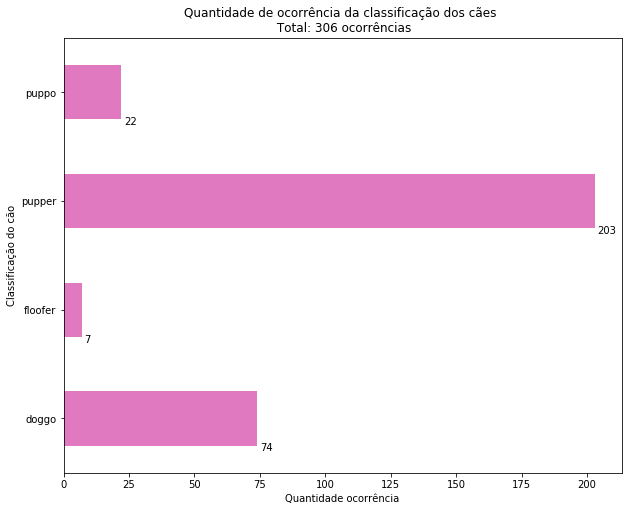

In [79]:
#quantidade de cada classificação dos cães
classificacao = df5.groupby('stage')['qtde'].sum().plot(kind='barh', figsize=(10,8), color=random.choice(colors))

# coloca a quantidade nas barras
for c in classificacao.patches:
    b=c.get_bbox()
    classificacao.annotate("{:.0f}".format(b.x1 + b.x0), (c.get_x() + c.get_width() + 1, c.get_y() - 0.05))
    
plt.title('Quantidade de ocorrência da classificação dos cães \n Total: '+ str(df5['qtde'].sum())+ ' ocorrências')
plt.xlabel('Quantidade ocorrência')
plt.ylabel('Classificação do cão')
plt.show()